In [ ]:
"""
Input Missing Values
Data Distribution
Data Transformation from numerical to categorical column values
Label Encoding some categorical varibles that may contain some information in their ordering set.
Getting Dummy Variables for categorical features
"""

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm,skew
from scipy import stats
from sklearn.metrics import mean_squared_error,mean_absolute_error
import xgboost as xgb
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge,RidgeCV,LassoCV
from sklearn.model_selection import cross_val_score


In [2]:
#trainData = pd.read_csv("C:/Users/Kaggle/Kaggle/Kaggle/house-prices-advanced-regression-techniques/train.csv")
#testData = pd.read_csv("C:/Users/Kaggle/Kaggle/Kaggle/house-prices-advanced-regression-techniques/test.csv")
trainData = pd.read_csv("train.csv")
testData = pd.read_csv("test.csv")


('Skewness', 1.8828757597682129)
('Kurtosis', 6.536281860064529)
('Date Types', Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         i

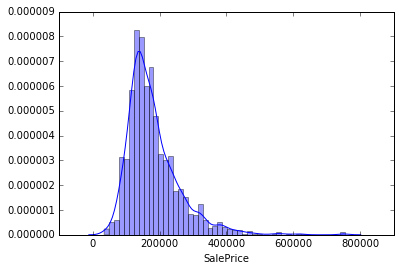

In [3]:
"""
Deviate from the normal distribution.
Have appreciable positive skewness.
Show peakedness.
"""

trainData.MSZoning.unique()
trainData['SalePrice'].describe()
sns.distplot(trainData['SalePrice'])
print('Skewness',trainData['SalePrice'].skew())
print('Kurtosis',trainData['SalePrice'].kurt())
print("Date Types",trainData.dtypes)

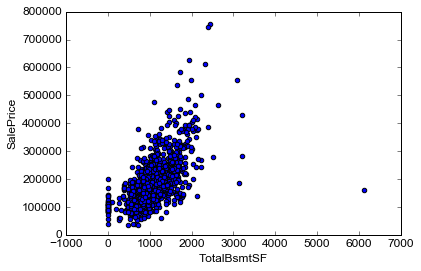

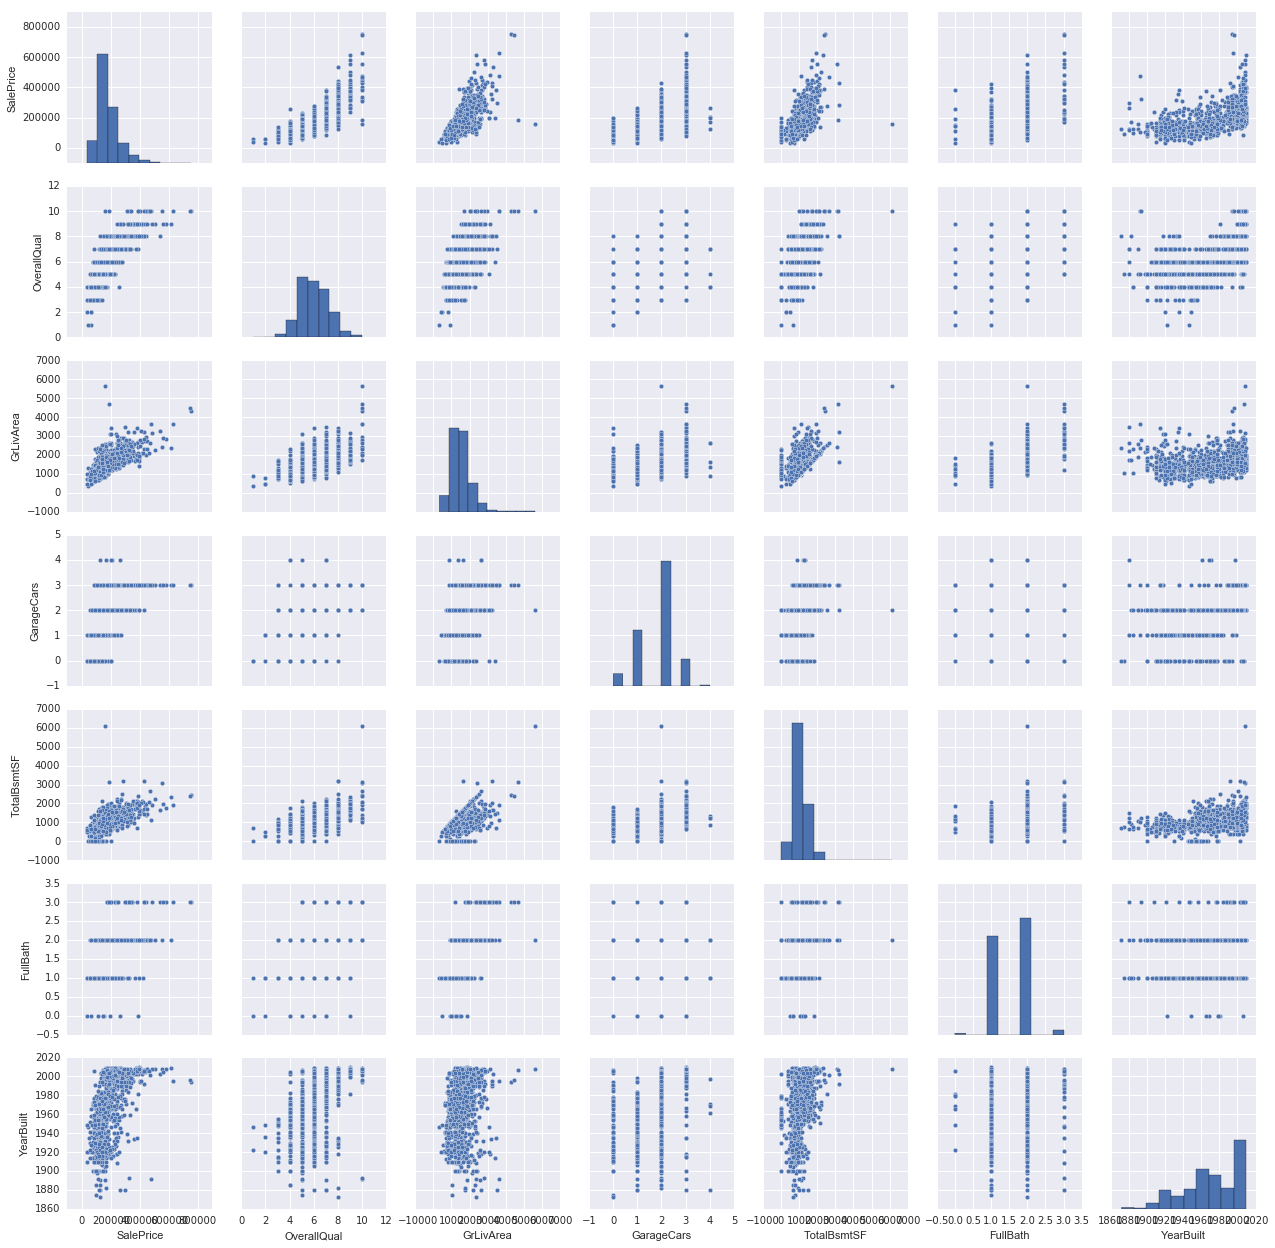

In [4]:
"""
Variable Distribution
"""

#scatter plot totalbsmtsf/saleprice - linear relationship
var = 'TotalBsmtSF'
data = pd.concat([trainData['SalePrice'], trainData[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(trainData[cols], size = 2.5)
plt.show();

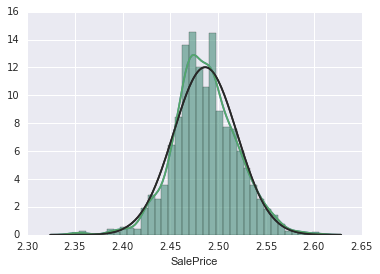

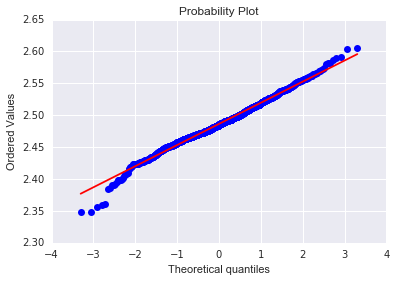

In [6]:
"""
SKEWED FEATURES
In case of positive skewedness, log transformations usally works.
Histogram - Kurtosis and skewness.
Normal probability plot - Data distribution should closely follow the diagonal that represents the normal distribution.
"""
#sns.distplot(trainData['SalePrice'],fit=norm)
trainData['SalePrice'] = np.log(trainData['SalePrice'])
sns.distplot(trainData['SalePrice'],fit=norm)

#histogram and normal probability plot
sns.distplot(trainData['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(trainData['SalePrice'], plot=plt)
trainData['GrLivArea'] = np.log(trainData['GrLivArea'])



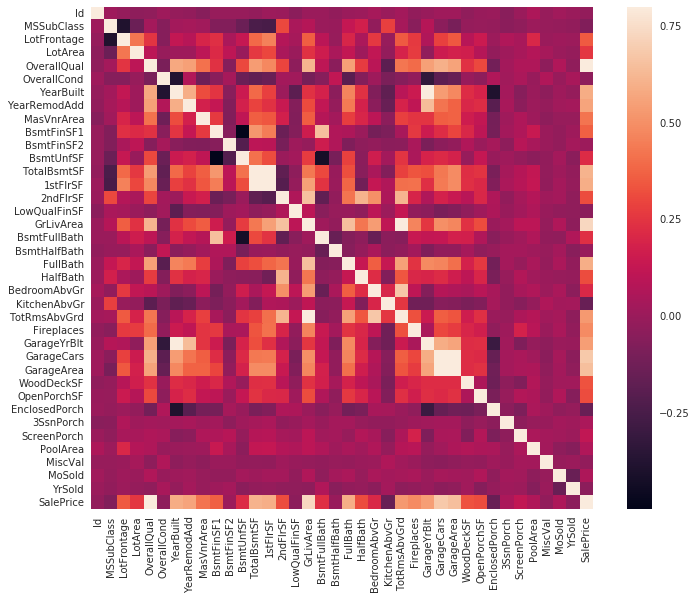

In [7]:
"""
Correlation Matrix
"""
corrmat = trainData.corr()
f,ax = plt.subplots(figsize = (12,9))
sns.heatmap(corrmat,vmax=0.8,square=True)



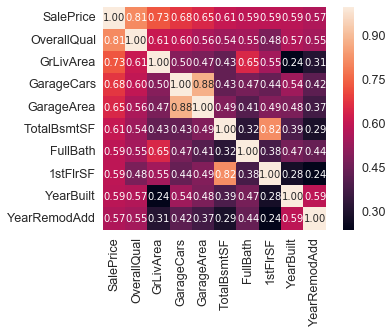

In [8]:
k=10
cols = corrmat.nlargest(k,'SalePrice')['SalePrice'].index
cm =  np.corrcoef(trainData[cols].values.T)
sns.set(font_scale=1.25)
cm = np.corrcoef(trainData[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()



In [9]:
ntrain = trainData.shape[0]
ntest = testData.shape[0]

all_data = pd.concat((trainData, testData)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 80)


In [10]:
"""
log transform skewed numeric features and transforming data int dummy variables.

"""
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = trainData[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats> 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [11]:
"""
Missing Data Imputations
"""
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)


,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageQual,5.447071
GarageCond,5.447071
GarageFinish,5.447071
GarageYrBlt,5.447071


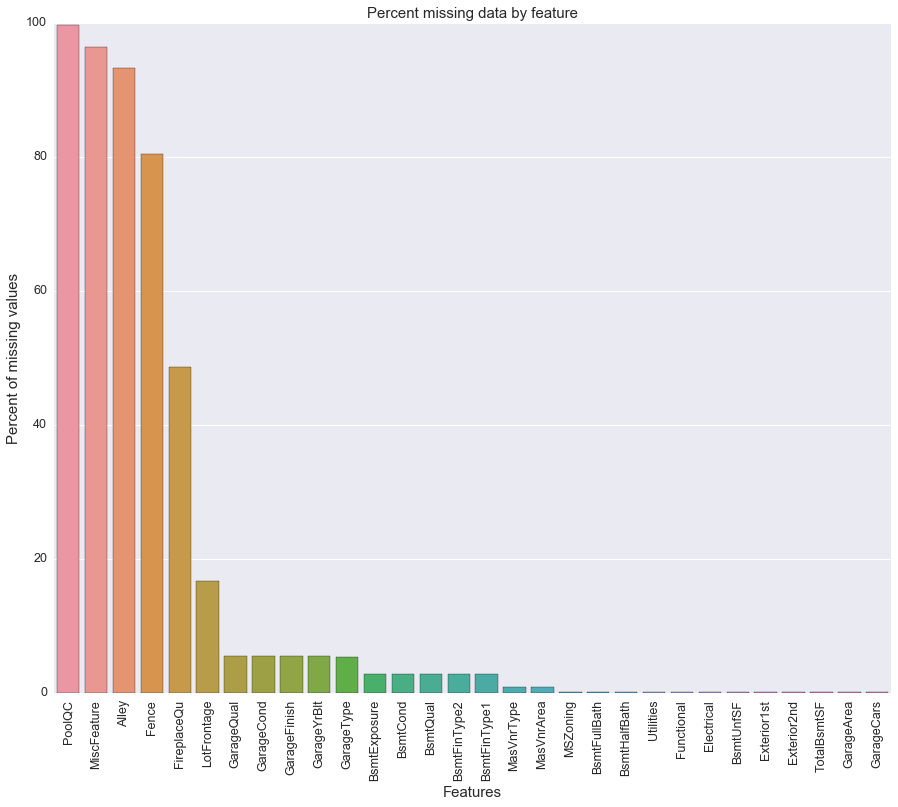

In [12]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [13]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

    
    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

all_data['GarageCars'] = all_data['GarageCars'].fillna(all_data['GarageCars'].mode()[0])
all_data['GarageArea'] = all_data['GarageArea'].fillna(0)
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(all_data['GarageYrBlt'].mode()[0])

In [14]:
"""
Data Transformations
Transforming some numerical variables that are really categorical variable.
"""
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [15]:
"""
Label Encoder

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))
    
print('Shape all_data: {}'.format(all_data.shape))
"""
all_data = pd.get_dummies(all_data)

In [ ]:
"""
Filtering columns having NAN.
"""
#all_data.columns[all_data.isnull().any()].tolist()
#all_data.isnull().sum()

In [17]:
"""
Model Building - Splittng Data into Train and Test Data. Target variable in other column variables
"""

Scaler = StandardScaler()
all_scaled = pd.DataFrame(Scaler.fit_transform(all_data))


X_train = all_data[:trainData.shape[0]]
X_test = all_data[trainData.shape[0]:]
y_train = trainData.SalePrice


In [18]:
"""
Ridge Regression Model (L2) - regulariztion the higher coefficient values of variable.
Lasso Regression  (L1) - feature selection and regularization of higher coefficent values

The main problem with lasso regression is when we have correlated variables, it retains only one variable and sets other correlated variables to zero. 
That will possibly lead to some loss of information resulting in lower accuracy in our model.
"""

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)



0.010913539607565564

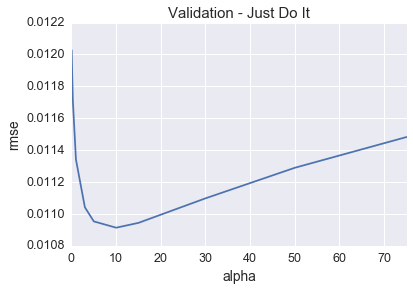

In [19]:
"""
Ridge Regression - L2 - Retains all the features but shrink it to almost 0
"""

model_ridge = Ridge()
alphas  =[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge,index=alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
cv_ridge.min()




In [ ]:
"""
Lasso Regression
The lasso performs even more bettwe
"""
model_lasso =  LassoCV(alphas=[1,0.1,0.001,0.0005]).fit(X_train,y_train)
rmse_cv(model_lasso).mean()


In [ ]:
"""
Nice! The lasso performs even better so we'll just use this one to predict on the test set. Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:
"""
coef = pd.Series(model_lasso.coef_,index=X_train.columns)
print("Lasso picked " +str(sum(coef !=0)) + " variables and elimated the other " + str(sum(coef == 0))+" variables")

In [ ]:
"""
Identifying the important coefficients
"""

imp_coef = pd.concat([coef.sort_values().head(10),coef.sort_values().tail(10)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [ ]:
"""
Prediction from Lasso Regression Model
"""
preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
preds



In [ ]:
lasso_preds = pd.DataFrame({'SalePrice':np.expm1(model_lasso.predict(X_test))})
lasso_preds['Id'] = testData['Id']
lasso_preds[['Id','SalePrice']]
lasso_preds.columns = ['SalePrice','Id']
lasso_preds.to_csv('sample_submission.csv',index=False)

In [21]:
"""

Hyperparameter tuning

dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test,label = y_test)

#params = {"max_depth":2, "eta":0.1}
#model = xgb.cv(params, dtrain,  num_boost_round=400, early_stopping_rounds=50)


params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
    'learning_rate':0.1,
    
}
params['eval_metric'] = "mae"
model = xgb.train(params,dtrain,num_boost_round=50,evals = [(dtest,"Test")],early_stopping_rounds=10)

print("Best MAE {:.2f} with {} rounds".format(model.best_score,model.best_iteration+1))
#num-boost_rounds = 50 & 
"""

"""
Xgboost Model 
"""

model_xgb = xgb.XGBRegressor(max_depth=3,learning_rate=0.1,n_estimators=50,reg_alpha=0.001,reg_lambda=0.000001,n_jobs=-1,min_child_weight=3)
model_xgb.fit(X_train,y_train)
"""
Training and Testing Score
"""
#print ("Training score:",model_xgb.score(X_train,y_train),"Test Score:",model_xgb.score(X_test,y_test))

y_pred = pd.DataFrame(np.expm1(model_xgb.predict(X_test)))
y_pred['Sale_Price'] = y_pred[0]
y_pred['Id'] = testData['Id']
y_pred.drop(0,axis=1,inplace=True)
y_pred[['Id','Sale_Price']]
y_pred.columns = ['SalePrice','Id']
y_pred.to_csv('sample_submission.csv',index=False)